<a href="https://colab.research.google.com/github/singhjyoti1997/Deep-Learning/blob/main/Virtual_try_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import torch.nn as nn
from PIL import Image, ImageDraw

In [3]:
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

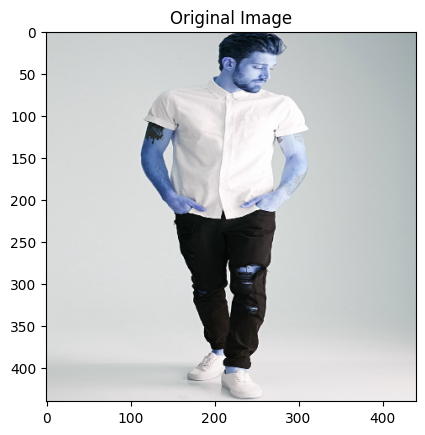

In [4]:
T_shirts = "/content/Shirts"
imagepath= "/content/images/5.jpg"
image = cv2.imread(imagepath)
image=cv2.resize(image,(440,440),interpolation=cv2.INTER_LINEAR)
# img_numpy = np.zeros((440, 440, 3), dtype=np.uint8)
# img = Image.fromarray(img_numpy, "RGB")
cv2.imwrite("orginal.jpg",image)
plt.imshow(image)
plt.title("Original Image")
plt.show()

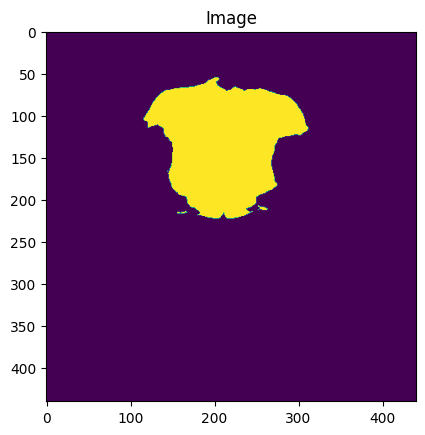

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits.cpu()
upsampled_logits = nn.functional.interpolate(
    logits,
    size=440,
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]
seg_array= np.array(pred_seg)
new_arr = np.zeros_like(seg_array)
# Copy values equal to 4 from arr to new_arr
new_arr[seg_array == 4] = 4

# showing segmented t-shirt
plt.imshow(new_arr)
plt.title("Image")
plt.show()

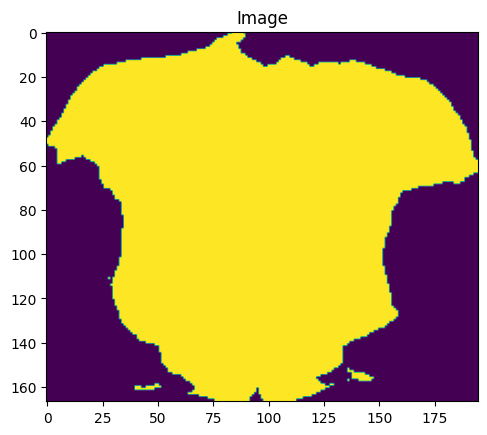

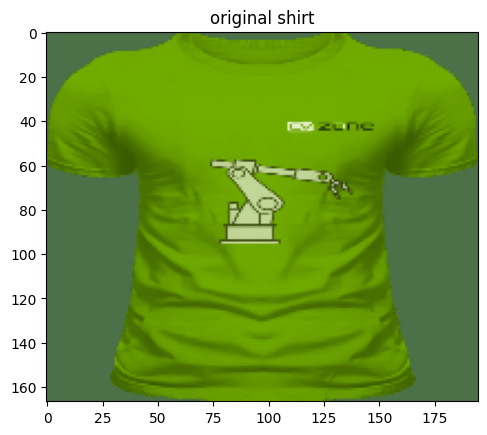

In [6]:
segmentation = np.where(new_arr==4)
x_min,x_max,y_min,y_max = 0, 0, 0, 0
if len(segmentation) != 0 and len(segmentation[1]) != 0 and len(segmentation[0]) != 0:
    x_min = int(np.min(segmentation[1]))
    x_max = int(np.max(segmentation[1]))
    y_min = int(np.min(segmentation[0]))
    y_max = int(np.max(segmentation[0]))
clipSeg=new_arr[y_min:y_max,x_min:x_max]
clipShirt= image[y_min:y_max,x_min:x_max]
plt.imshow(clipSeg)
plt.title("Image")
plt.show()
Shirt= cv2.imread("/content/Shirts/1.png")
Shirt=cv2.resize(Shirt,(x_max-x_min,y_max-y_min),interpolation=cv2.INTER_LINEAR)
Shirt=np.array(Shirt)
plt.imshow(Shirt)
plt.title("original shirt")
plt.show()

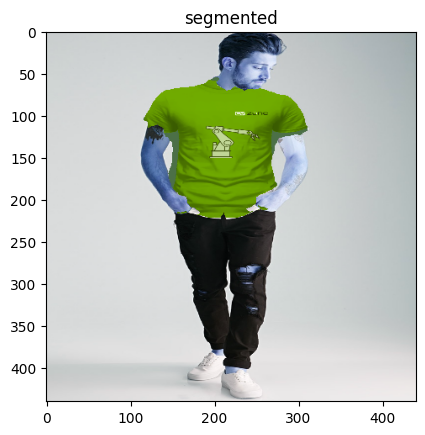

In [7]:
# Overlay the shirt onto the original image according to new_arr value 4
def overlay_shirt(image,cliped_image ,shirt_image, clipsegment_array,segment_value):
    # Create a mask for the shirt segment
    mask = np.zeros_like(clipsegment_array, dtype=np.uint8)
    mask[clipsegment_array == segment_value] = 255
    segment_coords = np.argwhere(clipsegment_array == segment_value)
        # Calculate bounding box
    min_coords = np.min(segment_coords, axis=0)
    max_coords = np.max(segment_coords, axis=0)
    width = max_coords[1] - min_coords[1]
    height = max_coords[0] - min_coords[0]

    # mask1= np.zeros_like(segment_array, dtype=np.uint8)
    # mask1[segment_array == segment_value] = 255
    # Resize the shirt image to match the dimensions of the original image
    shirt_resized = cv2.resize(shirt_image, (mask.shape[1], mask.shape[0]))

    # Invert the mask
    mask_inv = cv2.bitwise_not(mask)

    # Overlay the shirt onto the original image within the segmented region
    overlay = cv2.bitwise_and(shirt_resized, shirt_resized, mask=mask)
    background = cv2.bitwise_and(cliped_image, cliped_image, mask=mask_inv)
    result = cv2.add(background, overlay)
    image[y_min:y_max,x_min:x_max] = result
    return image

# Overlay the shirt onto the original image according to new_arr value 4
overlay_result = overlay_shirt(image,clipShirt, Shirt,clipSeg,segment_value=4)
# # Display the result
plt.imshow(overlay_result)
plt.title("segmented")
plt.show()